# MSM and MELD simulation analysis

___

In [1]:
import pyemma
import numpy as np
import glob
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import matplotlib
import matplotlib.pyplot as plt
import pyemma.coordinates as coor
import sys
import shutil
import os
from pyemma.util.contexts import named_temporary_file
from matplotlib.pyplot import cm
from collections import OrderedDict
import warnings
import seaborn as sns
from pandas import *
from matplotlib import gridspec
import matplotlib.patches as patches
warnings.filterwarnings('ignore')
cmaps = OrderedDict()
import itertools
from itertools import combinations
from contact_map import ContactFrequency, ContactDifference
import seaborn as sns
import mdtraj as md
import copy

In [6]:
###inter-residue distance feature for tICA calculation
all_feat = glob.glob('~/msm/proteinG_1mi0/Alltraj/Allfeatures*npz')
X = []
for feat in all_feat:
    feat = np.load(feat,allow_pickle=True)['arr_0']
    try:
        (ind_a,ind_b,ind_c) = feat.shape
        X += [feat[i,:,:] for i in range(ind_a)]
    except:
        ind_a = feat.shape
        X += feat.tolist()   
tica = coor.tica(coor.source(X), lag=50, dim=7, kinetic_map=True,reversible=True,weights='koopman')
tics=tica.get_output()

In [9]:
### include RMSD, native contact fraction features
all_rmsd = glob.glob('~/msm/proteinG_1mi0/Alltraj/RMSD*npz')
tics = tics[:]
both_features = copy.deepcopy(tics)
for feat in ['RMSD','native12Q','native34Q','nativeaQ','shifted12Q','native14Q']:
    X_feat = []
    feat = glob.glob(f'~/msm/proteinG_1mi0/Alltraj/{feat}*npz')
    for f in feat:
        f = np.load(f,allow_pickle=True)['arr_0']
        try:
            (ind_a,ind_b,ind_c) = feat.shape
            X_feat += [f[i,:,:] for i in range(ind_a)]
        except:
            ind_a = f.shape
            X_feat += f.tolist()
    X_feat = X_feat[:]
    for j in range(len(tics)):
        both_features[j] = np.append(X_feat, both_features[j], axis=1)
both_concate = np.concatenate(both_features)

In [10]:
pyemma.plots.plot_free_energy(both_concate[:,7],-1*both_concate[:,6])

In [11]:
cl = coor.cluster_kmeans(both_features, k=800, stride=20, max_iter=100)
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,5]
cc_y = cl.clustercenters[:,6]
plt.clf()
fig,ax=plt.subplots(1,3,figsize=(15,4))
pyemma.plots.plot_free_energy(both_concate[:,6],both_concate[:,7],ax=ax[0])
pyemma.plots.plot_free_energy(both_concate[:,6],both_concate[:,7],ax=ax[1])
pyemma.plots.plot_free_energy(both_concate[:,6],both_concate[:,7],ax=ax[2])
ax[0].scatter(cl.clustercenters[:,6],cl.clustercenters[:,7],c=cl.clustercenters[:,0], cmap="Greys",marker='.')
ax[1].scatter(cl.clustercenters[:,6],cl.clustercenters[:,7],c=cl.clustercenters[:,1], cmap="Blues",marker='*')
ax[2].scatter(cl.clustercenters[:,6],cl.clustercenters[:,7],c=cl.clustercenters[:,2], cmap="Reds",marker='x')

dtraj_concate = np.concatenate(dtrajs)

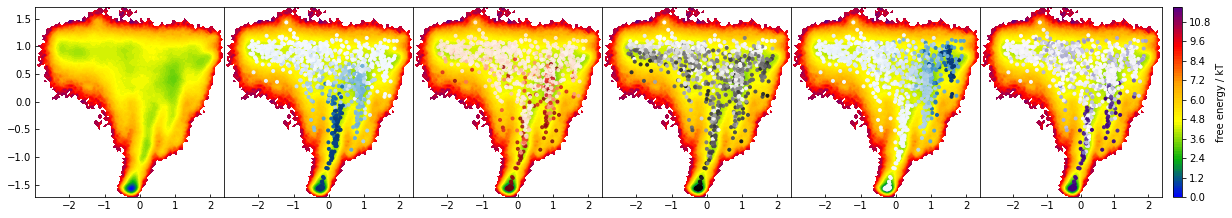

In [203]:
fig,ax=plt.subplots(1,6,figsize=(21,3.5),sharey=True,sharex=True,gridspec_kw={'width_ratios': [1,1, 1, 1, 1, 1.2]})
pyemma.plots.plot_free_energy(both_concate[:,7],-1*both_concate[:,6],ax=ax[0],cbar=False, weights=weights,cmap=cmaps.BlGrYeOrReVi200)
pyemma.plots.plot_free_energy(both_concate[:,7],-1*both_concate[:,6],ax=ax[1],cbar=False, weights=weights,cmap=cmaps.BlGrYeOrReVi200)
pyemma.plots.plot_free_energy(both_concate[:,7],-1*both_concate[:,6],ax=ax[2],cbar=False, weights=weights,cmap=cmaps.BlGrYeOrReVi200)
pyemma.plots.plot_free_energy(both_concate[:,7],-1*both_concate[:,6],ax=ax[3],cbar=False, weights=weights,cmap=cmaps.BlGrYeOrReVi200)
pyemma.plots.plot_free_energy(both_concate[:,7],-1*both_concate[:,6],ax=ax[4],cbar=False, weights=weights,cmap=cmaps.BlGrYeOrReVi200)
pyemma.plots.plot_free_energy(both_concate[:,7],-1*both_concate[:,6],ax=ax[5], weights=weights,cmap=cmaps.BlGrYeOrReVi200)

ax[1].scatter(cl.clustercenters[:,7],-1*cl.clustercenters[:,6],c=cl.clustercenters[:,4], cmap="Blues",marker='.')
ax[2].scatter(cl.clustercenters[:,7],-1*cl.clustercenters[:,6],c=cl.clustercenters[:,3], cmap="Reds",marker='.',alpha=0.8)
ax[3].scatter(cl.clustercenters[:,7],-1*cl.clustercenters[:,6],c=cl.clustercenters[:,2], cmap="Greys",marker='.')
ax[4].scatter(cl.clustercenters[:,7],-1*cl.clustercenters[:,6],c=cl.clustercenters[:,1], cmap="Blues",marker='.')
ax[5].scatter(cl.clustercenters[:,7],-1*cl.clustercenters[:,6],c=cl.clustercenters[:,0], cmap="Purples",marker='.')

plt.subplots_adjust(wspace=0, hspace=0)
ax[0].tick_params(direction="in", bottom=True, top=False, left=True, right=False)

for i in range(1,6):
    ax[i].tick_params(direction="in", bottom=True, top=False, left=False, right=False)
# plt.savefig("plots/fmap.pdf")


In [14]:
its = pyemma.msm.its(cl.dtrajs, lags=[1, 2, 5, 10, 20, 50, 100,120,140])#,150,180])
pyemma.plots.plot_implied_timescales(its, units='ns')
msm = pyemma.msm.bayesian_markov_model(dtrajs, lag=40)#,mincount_connectivity=0.2)

In [35]:
weights = []
active_set=msm.active_set
index_clusters = cl.index_clusters
dtrajs_concat = np.concatenate(dtrajs, axis=0)
mu = msm.stationary_distribution
for cluster_index in dtrajs_concat:
    if cluster_index not in active_set: weights.append(0.0)
    else:
        MSM_cluster_index = np.where(active_set == cluster_index)[0][0]
        num_conf_in_cluster = len(index_clusters[cluster_index])
        weights.append(mu[MSM_cluster_index] / num_conf_in_cluster)

(<Figure size 432x288 with 2 Axes>,
 {'mappable': <matplotlib.contour.QuadContourSet at 0x2b93a9460710>,
  'cbar': <matplotlib.colorbar.Colorbar at 0x2b93abdd6850>})

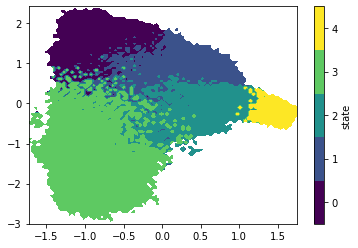

In [14]:
hmm=pyemma.msm.bayesian_hidden_markov_model(dtrajs,5, lag=30,stride=10,mincount_connectivity=0.2)
pyemma.plots.plot_state_map(both_concate[:,6],both_concate[:,7], hmm.metastable_assignments[dtraj_concate]) 
#plt.savefig('hmm.png')

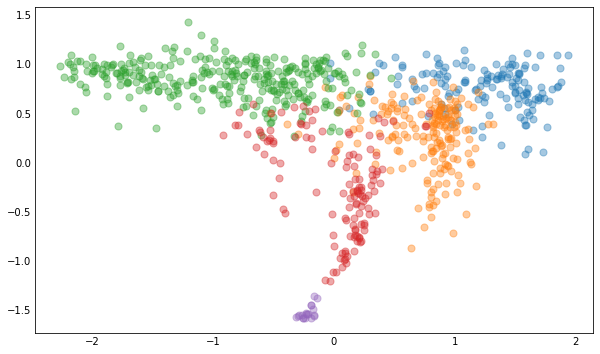

In [263]:
fig,ax=plt.subplots(1,1,figsize=(10,6))ax.tick_params(direction="in", bottom=False, top=False, left=False, right=False)
for i in range(5):
    ax.scatter(cl.clustercenters[:,7][hmm.metastable_assignments==i],-1*cl.clustercenters[:,6][hmm.metastable_assignments==i],alpha=0.4,s=50)
# plt.savefig('plots/hmm_7tica.pdf', transparent=True)

mfpt 3 -> 2 is 31.17 µs
mfpt 3 -> 0 is 53.24 µs
mfpt 3 -> 1 is 32.84 µs
mfpt 0 -> 2 is 38.58 µs
mfpt 0 -> 1 is 24.34 µs
mfpt 1 -> 2 is 37.34 µs
mfpt 2 -> 4 is 27.65 µs


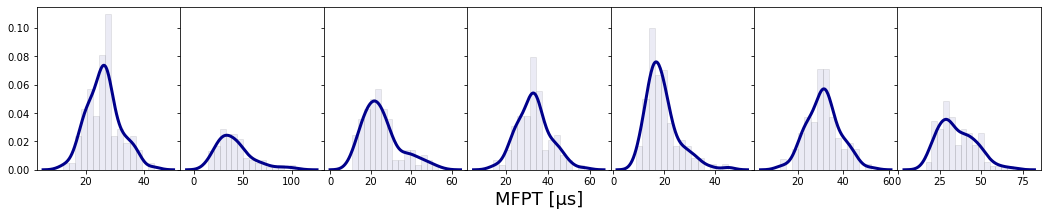

In [110]:
# hmm.sample_conf('lifetimes')
fig,ax=plt.subplots(1,7,figsize=(18,3),sharey=True)
for index,i in enumerate([[3,2],[3,0],[3,1],[0,2],[0,1],[1,2],[2,4]]):
    print(f'mfpt {i[0]} -> {i[1]} is {round(hmm.mfpt(i[0],i[1])/1000,2)} µs')
    mfpt=hmm.sample_f('mfpt',[i[0]],[i[1]])
    sns.distplot(np.array(mfpt)/1000, hist=True, kde=True, 
             bins=15, color = 'darkblue', 
             hist_kws={'edgecolor':'black','alpha':0.08},
             kde_kws={'linewidth': 3},ax=ax[index])
#     plt.hist(np.array(mfpt)/1000,density=True)
#     plt.show()
ax[3].set_xlabel('MFPT [µs]',fontsize=18)
    
ax[0].set_ylabel('',fontsize=13)
plt.subplots_adjust(wspace=0, hspace=0)
# for i in range(7):
#     ax[i].tick_params(axis='y',which='both',left=False,right=False,labelleft=False,labelright=False,labelbottom=False)
#     ax[i].tick_params(axis='x',which='both',left=False,right=False,bottom=False,labelleft=False,labelright=False,labelbottom=False)
#     ax[i].tick_params(axis='x',which='both',left=False,right=False,bottom=False,labelleft=False,labelright=False,labelbottom=False)
# plt.savefig('')
hmm.stationary_distribution
# plt.savefig('./plots/sampled_mfpt.pdf',bbox_inches = "tight")


In [206]:
A = [2]
B = [4]
flux = pyemma.msm.tpt(hmm, A, B)
state_labels=['0','1','2','3','4']#,'B']#,'7']#,'A','B']

(-3.005995273590088, 2.4271228313446045)

<Figure size 432x288 with 0 Axes>

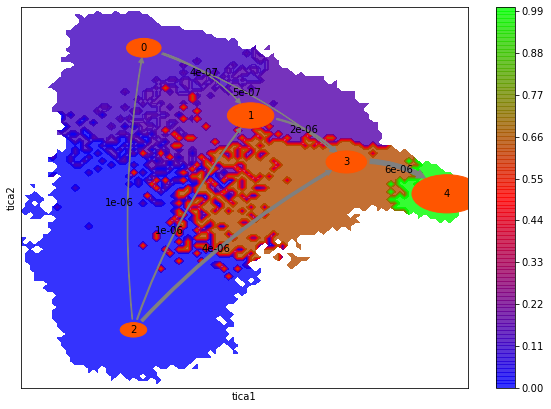

In [207]:
highest_membership = hmm.metastable_distributions.argmax(1)
coarse_state_centers = cl.clustercenters[hmm.observable_set[highest_membership]]
plt.clf()
fig, ax = plt.subplots(figsize=(10, 7))

pyemma.plots.plot_contour(
    both_concate[:,6],both_concate[:,7],
    flux.committor[hmm.metastable_assignments[dtraj_concate]],
    cmap='brg',
    ax=ax,
    mask=True,
 #   cbar_label=r'committor {} $\to$ 3'.format(i),
    alpha=0.8,
    zorder=-1)

pyemma.plots.plot_flux(
    flux,
    coarse_state_centers[:,6:],
    flux.stationary_distribution,
    ax=ax,
    minflux=10e-8,
    show_committor=False,
    figpadding=0,
    show_frame=True,
    state_labels= state_labels)
   # arrow_label_format='%2.e / ps');

ax.set_xlabel('tica1')
ax.set_ylabel('tica2')
ax.set_xlim(both_concate[:,6].min(), both_concate[:,6].max())
ax.set_ylim(both_concate[:,7].min(), both_concate[:,7].max())
#plt.savefig('5states/flux_{}_3_n1.png'.format(12))

In [208]:
hmm_sets = hmm.metastable_sets
cg, cgflux = flux.coarse_grain(hmm_sets)
paths, path_fluxes = cgflux.pathways(fraction=0.99)
print('percentage       \tpath')
print('-------------------------------------')
for i in range(len(paths)):
    print((path_fluxes[i] / np.sum(path_fluxes)),' \t', paths[i])
print(cg)

percentage       	path
-------------------------------------
0.6134227400998699  	 [0 2 4]
0.23403921787519946  	 [0 1 2 4]
0.08570594459827435  	 [0 3 2 4]
0.06683209742665631  	 [0 3 1 2 4]
[OrderedSet([2]), OrderedSet([1]), OrderedSet([3]), OrderedSet([0]), OrderedSet([4])]


In [2]:
import mdtraj as md
traj = md.load('../1mi0.leap.pdb')
native_12 = md.compute_contacts(traj,scheme="ca",contacts=[[1+i,20-i] for i in range(8)])
native_34 = md.compute_contacts(traj,scheme="ca",contacts=[[42+i,55-i] for i in range(5)])
native_12_rs = md.compute_contacts(traj,scheme="ca",contacts=[[4+i,18-i] for i in range(4)])
samples=375498
# native_124 = md.compute_contacts(traj,[[42+i,55-i] for i in range(5)])
a = np.ones((samples,8))
a[:] = native_12[0] 
native_12 = a
b = np.ones((samples,5))
b[:] = native_34[0] 
native_34 = b
c = np.ones((samples,4))
c[:] = native_12_rs[0] 
native_12_rs = c

In [12]:
index=[str(0)+str(i) for i in range(10)]+[str(i) for i in range(10,40)]
traj = md.load('../1mi0.leap.pdb')
CA_21 = list(traj_all.top.select_atom_indices('alpha')[0:8])+list(traj_all.top.select_atom_indices('alpha')[12:20])
CA_43 = list(traj_all.top.select_atom_indices('alpha')[42:46])+list(traj_all.top.select_atom_indices('alpha')[51:55])

CA_2143 = CA_21+CA_43
all_ss = CA_2143 + list(traj_all.top.select_atom_indices('alpha')[21:36])

CA_alpha = list(traj_all.top.select_atom_indices('alpha')[21:36])
CA_21a = CA_21+CA_alpha
aaa=[]
q_21=[]
q_43=[]
q_2143=[]
q_a=[]
q_all=[]
folded_26=[]
# q_21s=[]
for i in range(30):
    base_dir = '~/msm/proteinG_1mi0/whichone_run_00_longer/longer_extend/'
    traj_file=base_dir+'follow.'+index[i]+'.dcd'
    traj_all = md.load_dcd(traj_file,top='../1mi0.leap.pdb')[-1*samples:]
    CA_21 = list(traj_all.top.select_atom_indices('alpha')[0:8])+list(traj_all.top.select_atom_indices('alpha')[12:20])
    CA_43 = list(traj_all.top.select_atom_indices('alpha')[42:46])+list(traj_all.top.select_atom_indices('alpha')[51:55])
    CA_2143 = CA_21+CA_43
    q_21.append(best_hummer_q(traj_file,traj,selected=list(range(0,157)))[-1*samples:])
    q_43.append(best_hummer_q(traj_file,traj,selected=list(range(-122,-1)))[-1*samples:])
    q_a.append(best_hummer_q(traj_file,traj,selected=list(range(167,282)))[-1*samples:])
    q_2143.append(best_hummer_q(traj_file,traj,selected=list(range(0,157))+list(range(-122,-1)))[-1*samples:])
    q_all.append(best_hummer_q(traj_file,traj,selected=list(range(0,157))+list(range(167,282))+list(range(-122,-1)))[-1*samples:])
    q_21s.append(best_hummer_q(traj_file,traj,selected=list(range(12,68))+list(range(90,146)))[-1*samples:])

    all_ss = CA_2143 + list(traj_all.top.select_atom_indices('alpha')[21:36])
    all_rmsd = md.rmsd(traj_all,traj,atom_indices=all_ss)
    aaa.append(all_rmsd)
# np.savez(base_dir+'/q_value/'+'q21_traj',q_21)
# np.savez(base_dir+'/q_value/'+'q43_traj',q_43)
# np.savez(base_dir+'/q_value/'+'qa_traj',q_a)
# np.savez(base_dir+'/q_value/'+'q2143_traj',q_2143)
# np.savez(base_dir+'/q_value/'+'qall_traj',q_all)
# np.savez(base_dir+'/q_value/'+'all_rmsd_traj',aaa)
# np.savez(base_dir+'/q_value/'+'q21s_traj0_temp',q_21s)

   

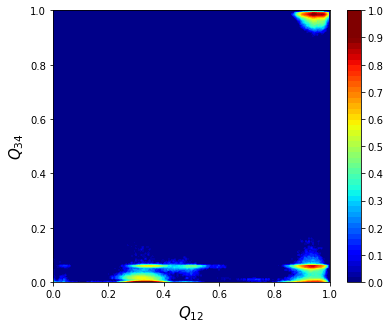

In [14]:
fig,ax=plt.subplots(1,1,figsize=(6.2,5))
# data=pandas.DataFrame(np.vstack((np.concatenate(q_21[0][:]),np.concatenate(q_43[0][:]))).T,columns=['b21','b43'])
# a=sns.jointplot(x='b21',y='b43', kind = "kde", ax=ax,data=data,space=0,color='b')
# a=ax.scatter(q_21[0],q_43[0],s=1,c=q_all[0],cmap='cividis')
xedges=yedges=np.arange(0,1,0.01)

H, xedges, yedges, qm=ax.hist2d(np.concatenate(q_21[0]),np.concatenate(q_43[0]),bins=200,density=True,cmap='jet')
xedges=np.array([xedges[i] for i in range(H.shape[0])])
yedges=np.array([yedges[i] for i in range(H.shape[0])])
H = 0.4*np.log(H)/(0.4*np.log(H).max())
H[H<0]=0
a=ax.contourf(xedges, yedges, H.T,50,vmin=0,vmax=0.9,cmap='jet')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.colorbar(a)
a.colorbar.set_ticks(np.arange(0,1.1,0.1))

ax.set_xlabel(r'$Q_{12}$',fontsize=15)
ax.set_ylabel(r'$Q_{34}$',fontsize=15)

# plt.savefig('plots/histmeldbeta.pdf')


In [85]:
base_dir = '~/msm/proteinG_1mi0/whichone_run_00_longer/longer_extend/'
q_all=np.load(base_dir+'/q_value/qall_traj.npz',allow_pickle=True)['arr_0']
q_a=np.load(base_dir+'/q_value/qa_traj.npz',allow_pickle=True)['arr_0']
q_21=np.load(base_dir+'/q_value/q21_traj.npz',allow_pickle=True)['arr_0']
q_43=np.load(base_dir+'/q_value/q43_traj.npz',allow_pickle=True)['arr_0']
q_2143=np.load(base_dir+'/q_value/q2143_traj.npz',allow_pickle=True)['arr_0']
aaa=np.load(base_dir+'/q_value/all_rmsd_traj.npz',allow_pickle=True)['arr_0']


In [13]:
def normalize(x):
    return (x - x.min(0)) / x.ptp(0)
base_dir = '~/msm/proteinG_1mi0/whichone_run_00_longer/longer_extend//q_value/'

all_x=[]
all_y=[]

fig,ax= plt.subplots(30,1,figsize=(10,8))#,sharey=True, gridspec_kw={'width_ratios': [1, 1.89]})
x=np.load(base_dir+'all_rmsd_traj.npz',allow_pickle=True)['arr_0'][26]
x = DataFrame({'a': x*10})

g=sns.distplot(x,kde=True,bins=50,ax=ax[26],color='white',hist_kws=dict(alpha=0.0),label=r'$\beta_{12}$',kde_kws=dict(linewidth=4,alpha=0.1))
line = g.get_lines()[0]
xd = line.get_xdata()
all_x.append(xd)
yd = line.get_ydata()
yd2 = normalize(yd)
all_y.append(yd2)

print(g.get_lines()[0].get_ydata()[:4])
ax[26].plot(xd,yd2,c='red',linewidth=4)

for i in list(range(26))+list(range(27,30)):
    base_dir = '~/msm/proteinG_1mi0/whichone_run_00_longer/longer_extend//q_value/'
    x1=np.load(base_dir+f'all_rmsd_traj.npz',allow_pickle=True)['arr_0'][i]
    x1 = DataFrame({'a': x1*10})
    g1=sns.distplot(x1,kde=True,bins=50,ax=ax[i],color='white',hist_kws=dict(alpha=0.0),label=r'$\beta_{12}$',kde_kws=dict(linewidth=2))

    print(g1.get_lines()[0].get_ydata()[:4])
    line1 = g1.get_lines()[0]
    xd1 = line1.get_xdata()
    all_x.append(xd1)

    yd1 = line1.get_ydata()
    yd2 = normalize(yd1)
    all_y.append(yd2)
    ax[i].plot(xd1,yd2,c='lightgray',linewidth=2)


(-0.02, 1.03)

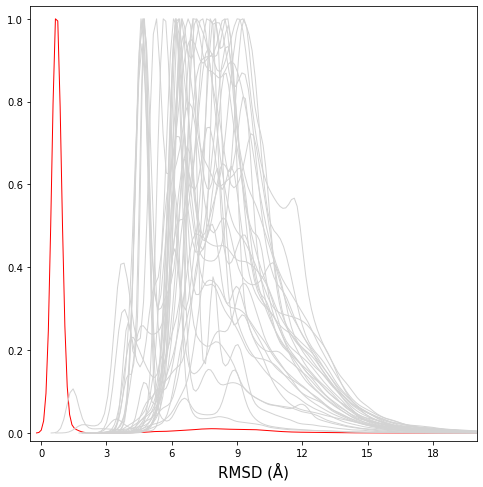

In [299]:
fig,ax= plt.subplots(1,1,figsize=(8,8))
ax.plot(all_x[0],all_y[0],c='red',linewidth=1)

for i in range(1,30):
    ax.plot(all_x[i],all_y[i],c='lightgray',linewidth=1)
ax.set_xlim(-0.5,20)
ax.set_xticks(range(0,20,3))
ax.set_xlabel('RMSD (Å)',fontsize=15)
# ax.set_xlim(0,1)
ax.set_ylim(-0.02,1.03)


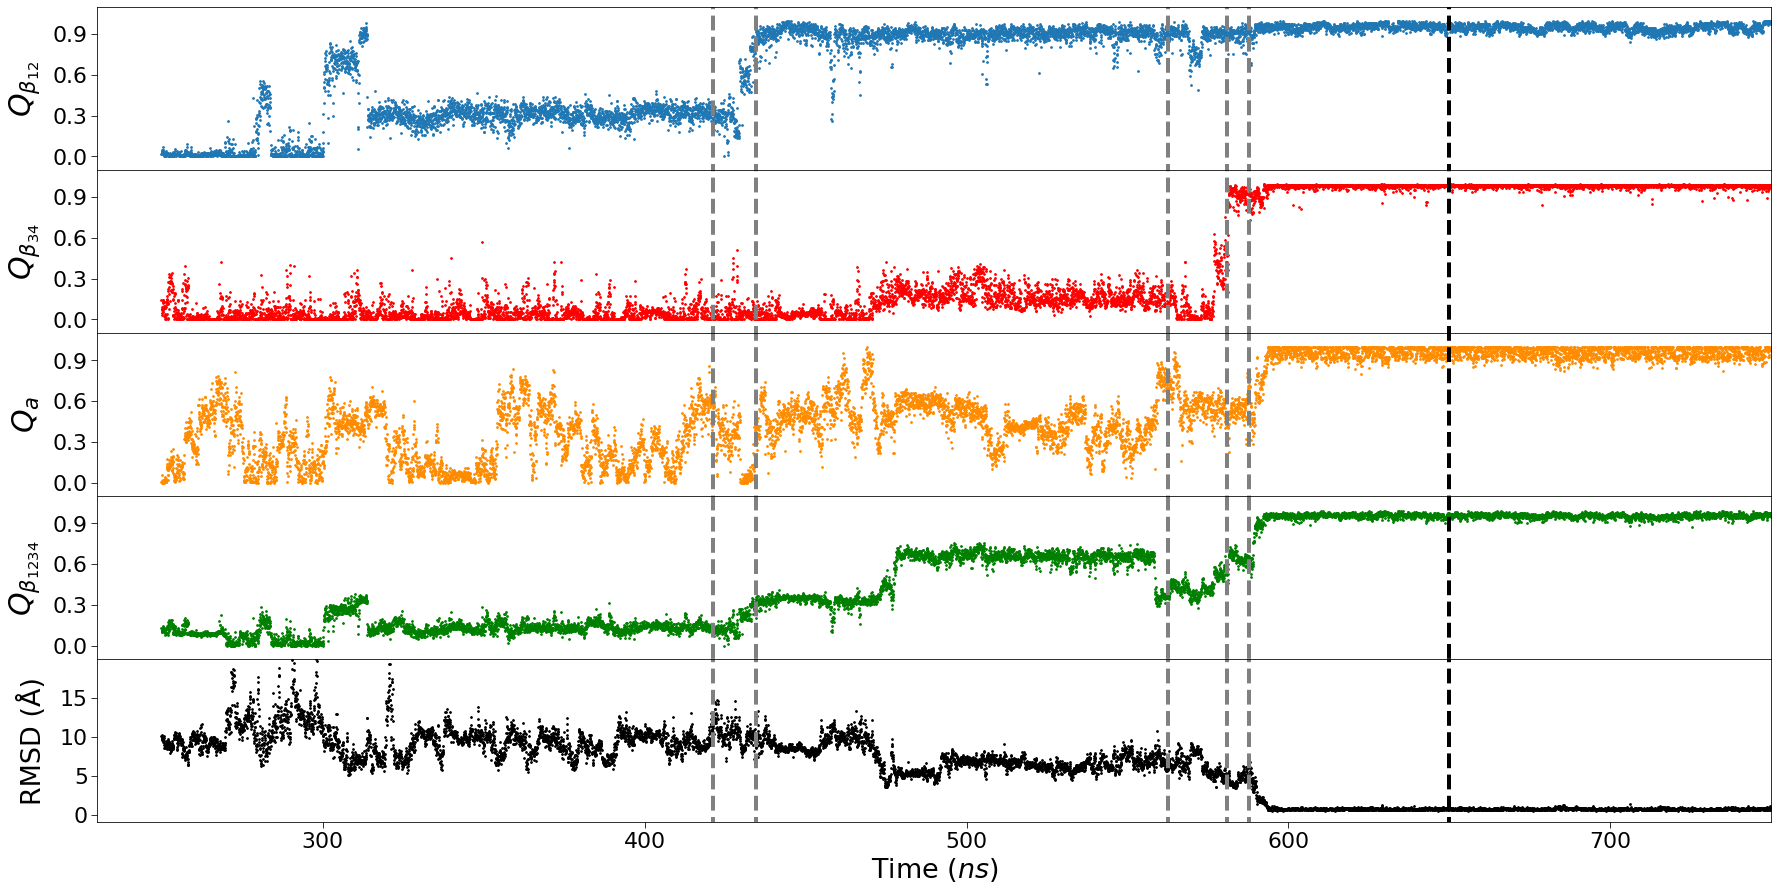

In [193]:
start=5000;end=15000;i=0
fig,ax=plt.subplots(5,1,sharex=True,figsize=(30,15))
i=26
ax[0].scatter((np.arange(len(q_21[i][start:end]))+4998)*0.05,q_21[i][start:end],s=3)
ax[1].scatter((np.arange(len(q_43[i][start:end]))+4998)*0.05,q_43[i][start:end],s=3,c='r')
ax[2].scatter((np.arange(len(q_a[i][start:end]))+4998)*0.05,q_a[i][start:end],s=3,c='darkorange')
ax[3].scatter((np.arange(len(q_2143[i][start:end]))+4998)*0.05,q_2143[i][start:end],s=3,c='g')

ax[4].scatter((np.arange(len(aaa[i][start:end]))+4998)*0.05,aaa[i][start:end]*10,s=3,c='k')
ax[4].set_yticks(range(0,20,5))
for i in range(5):
    ax[i].plot([(13000)*0.05,(13000)*0.05],[-5,20],'k',linestyle='dashed',linewidth=4)
    ax[i].plot([(11757)*0.05,(11757)*0.05],[-5,20],'gray',linestyle='dashed',linewidth=4)
    ax[i].plot([(11620)*0.05,(11620)*0.05],[-5,20],'gray',linestyle='dashed',linewidth=4)
    ax[i].plot([(11250)*0.05,(11250)*0.05],[-5,20],'gray',linestyle='dashed',linewidth=4)
    ax[i].plot([(8692)*0.05,(8692)*0.05],[-5,20],'gray',linestyle='dashed',linewidth=4)
    ax[i].plot([(8424)*0.05,(8424)*0.05],[-5,20],'gray',linestyle='dashed',linewidth=4)

for i in range(4):
    ax[i].set_ylim(-0.1,1.1)
    ax[i].set_xlim(230,750)
    ax[i].tick_params(axis='x', size=6,labelsize = 22)
    ax[i].tick_params(axis='y', size=6,labelsize = 22)
    ax[i].set_yticks(np.arange(0,1,0.3))
    ax[i].yaxis.set_label_coords(-0.033,0.5)

ax[4].tick_params(axis='both', size=6)
ax[4].tick_params(axis='y', size=6,labelsize = 22)
ax[4].yaxis.set_label_coords(-0.03,0.5)
ax[4].set_ylim(-1,20)
ax[0].set_ylabel(r'$Q_{\beta_{12}}$',fontsize=30)
ax[1].set_ylabel(r'$Q_{\beta_{34}}$',fontsize=30)
ax[2].set_ylabel(r'$Q_{a}$',fontsize=30)
ax[3].set_ylabel(r'$Q_{\beta_{1234}}$',fontsize=30)
ax[4].set_xlabel('Time ($ns$)',fontsize=27)
ax[4].set_ylabel('RMSD (Å)',fontsize=27)
ax[4].set_yticks(ticks=[0,5,10,15])
plt.xticks(fontsize=22)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('./plots/folding_traj26_5000_15000.pdf')


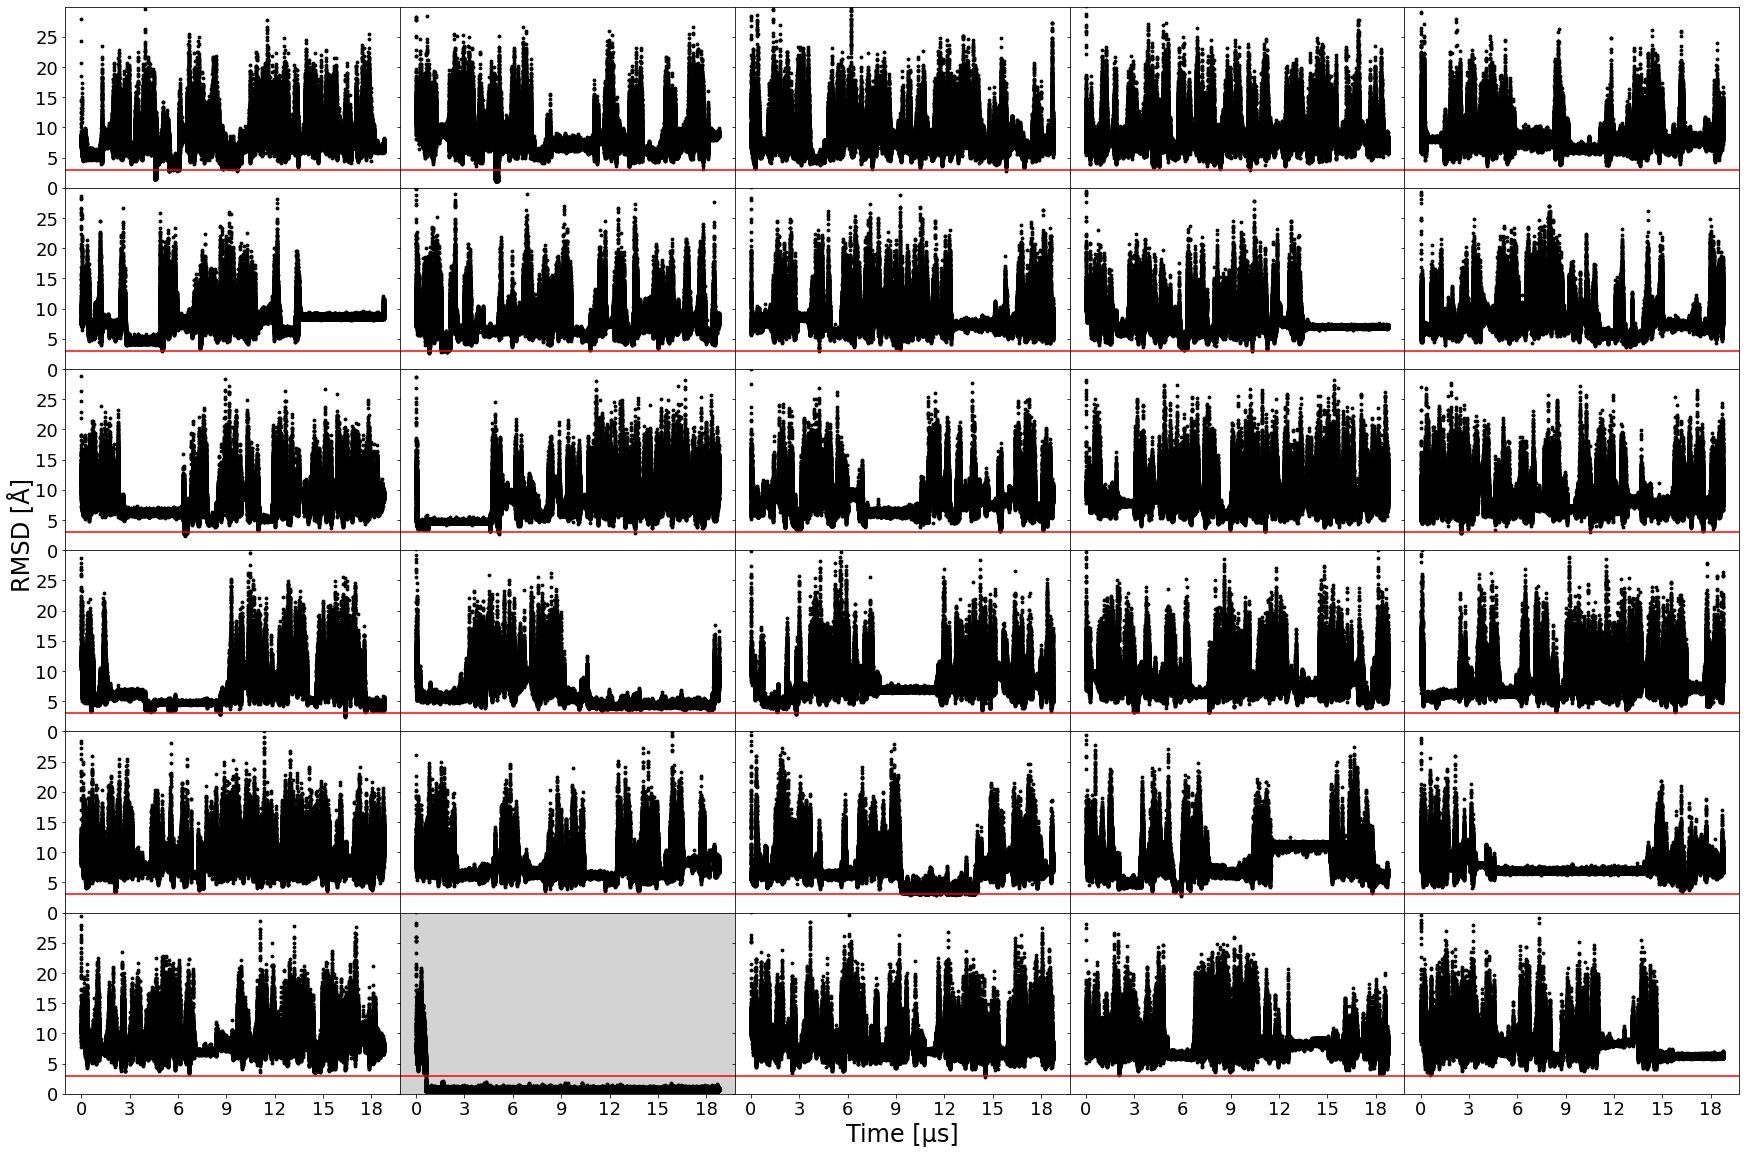

In [99]:
fig,ax=plt.subplots(6,5,figsize=(30,20),sharey=True, sharex=True)

for i in range(6):
    for j in range(5):
        ax[i][j].scatter(np.arange(len(aaa[i*5+j]))/20000,aaa[i*5+j]*10,s=8,color='black',label=f'walker {i*5+j}')
        ax[i][j].plot([-1,len(aaa[i*5+j])/20000+1],[3,3],'r')
        ax[i][j].set_ylim(0,30)
        ax[i][j].set_xlim(-1,len(aaa[i*5+j])/20000+1)
#         ax[i][j].set_yticks([0,6,12,18,24,30])
        if i!=5:
            ax[i][j].set_yticks([5,10,15,20,25])
#         ax[i][j].legend(frameon=False)
        ax[5][j].tick_params(axis='x', which='major', labelsize=18)
        ax[5][j].set_xticks([0.0,3,6,9,12,15,18])
    ax[i][0].tick_params(axis='y', which='major', labelsize=18)
ax[5][0].set_yticks([0,5,10,15,20,25])
ax[5][2].set_xlabel('Time [µs]',fontsize=24)
ax[3][0].text(-4.6,24,'RMSD [Å]',rotation=90,fontsize=24)
rect = ax[5][1].patch
rect.set_facecolor('lightgray')
# plt.savefig('./plots/all_walkers_rmsd.pdf',bbox_inches = "tight")

plt.subplots_adjust(wspace=0, hspace=0)
